In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from pandas.core.common import flatten

import torch
import os
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import  DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import random
import glob as glob
from skimage import io 

import sys
sys.path.insert(0, "/Users/alex_christlieb/Documents/Ecole Polytechnique/Exchange/DTU/Courses/Deep Learning/autotetris")

from lib.dataloader import RoofDataSet, Transforms, show_centroids
from lib.modeltraining import SqrtVarDiffloss, Resnet50_GAP,  train_model, test_model,  train_model, test_model, plot_CAM, plot_losses, plot_losses_together


# Note
The file ``lib.modeltraining`` contains all the code for the models, loss functions and trainings functions, as well as some assistant plotting functions. 

Thje file ``lib.dataloader``containts our Dataloader and Transformer, which are custom made to deal with our dataset.

#### Load Data

Using the defined classes and functions in `dataloader.py`, it is easy to load the dataset. 

In [2]:
# The path to the metadata.hdf file must be stored in a string
path = "small_sample_out/metadata_sample.hdf"

For confidentiality reasons, we can only disclose a very limited version of the dataset. 

The following code loads the data into a dataset. The `transform` argument in the `Transforms()` allows for a series of transformations to be called, where the input must be a list of transform functions. By default, it is configured to `['resize', 'to_tensor']`.

In [3]:
dataset = RoofDataSet(path, transform=Transforms(transform_list=["resize", "to_tensor"]), mode = "constant")

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


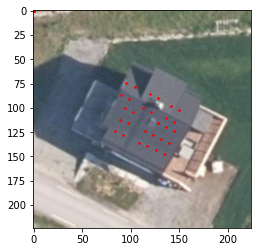

In [4]:
# Querying an index in the data loader
img, centroid = dataset[7]

show_centroids(img, centroids=centroid, tensor=True)

Split datasets

In [5]:
# split the dataset into training, validation and test sets
# Create testset
len_test_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_test_set

train_dataset , test_dataset  = torch.utils.data.random_split(dataset, [len_train_set, len_test_set],  generator=torch.Generator().manual_seed(1))

len_valid_set = int(0.2*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set],  generator=torch.Generator().manual_seed(1))

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
test_trained = DataLoader(train_dataset, batch_size=1, shuffle=True)

The length of Train set is 24
The length of Valid set is 6
The length of Test set is 3


### Train Model - Regression 

Note that the results will not be accurate since the dataset is very small. 

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

network = Resnet50_GAP(num_classes=dataset.max_num_panels*2)
network.to(device)
# print(network)

# Adjust network parameter
criterion = SqrtVarDiffloss()
# SGD diverges on our model
# optimizer = optim.SGD(network.parameters(), lr=0.0001)
optimizer = optim.Adam(network.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, cycle_momentum=False)

loss_min = 0.001
num_epochs = 10

# Train model
model = train_model(network, criterion, optimizer, num_epochs, train_loader, valid_loader, device)


cpu
Valid Steps: 1/1  Loss: 1151.5728 
--------------------------------------------------
Epoch: 1  Train Loss: 1302.2812  Valid Loss: 1151.5728
--------------------------------------------------
Valid Steps: 1/1  Loss: 1148.1924 
--------------------------------------------------
Epoch: 2  Train Loss: 1297.0253  Valid Loss: 1148.1924
--------------------------------------------------
Valid Steps: 1/1  Loss: 1144.5513 
--------------------------------------------------
Epoch: 3  Train Loss: 1266.6208  Valid Loss: 1144.5513
--------------------------------------------------
Valid Steps: 1/1  Loss: 1141.2092 
--------------------------------------------------
Epoch: 4  Train Loss: 1228.4283  Valid Loss: 1141.2092
--------------------------------------------------
Valid Steps: 1/1  Loss: 1139.0745 
--------------------------------------------------
Epoch: 5  Train Loss: 1233.1008  Valid Loss: 1139.0745
--------------------------------------------------
Valid Steps: 1/1  Loss: 1136.6974 
-

In [20]:
image, centroid = test_dataset[2]
image = image.unsqueeze(0)

In [21]:
heatmap, original_prediction = model(image, heatmap = True)

map = torch.mean(heatmap, dim = (0,1)) #Averaging over features 
map = map.unsqueeze(dim=0)
map = map.unsqueeze(dim=1)  #Expanidng channels 
upscale = torch.nn.Upsample(scale_factor=32, mode='bicubic', recompute_scale_factor=True) #Upscaling
map = upscale(map)
map = map/torch.max(map) #Normalizing

image_plot = image.squeeze()
image_plot = image_plot.permute(1, 2, 0)
prediction = original_prediction.view(-1,35, 2)
prediction = prediction.detach().numpy()
prediction = prediction[0]



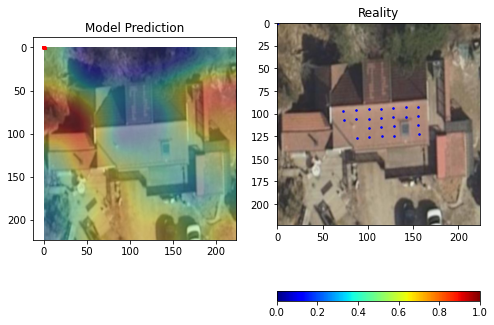

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="jet"), location = "bottom")
ax[0].imshow(image_plot)
ax[0].imshow(map[0][0].detach(), alpha=0.3, cmap ='jet')
ax[0].scatter(prediction[:, 1], prediction[:, 0], s=10, marker='.', c='r')
# ax[0].x_ticks()
ax[0].set_title("Model Prediction")

ax[1].imshow(image_plot)
ax[1].scatter(centroid[:, 1], centroid[:, 0], s=10, marker='.', c='b')
ax[1].set_title("Reality")
plt.show()

## Load Trained Model - Regression 

In [12]:
Path = "trained_models/resnet_GAP50_cyclic_10_07_12_22_a.pt"
model = torch.load(Path, map_location=torch.device('cpu'))
model.eval()

Resnet50_GAP(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [13]:
image, centroid = test_dataset[2]
image = image.unsqueeze(0)

In [14]:
heatmap, original_prediction = model(image, heatmap = True)

map = torch.mean(heatmap, dim = (0,1)) #Averaging over features 
map = map.unsqueeze(dim=0)
map = map.unsqueeze(dim=1)  #Expanidng channels 
upscale = torch.nn.Upsample(scale_factor=32, mode='bicubic', recompute_scale_factor=True) #Upscaling
map = upscale(map)
map = map/torch.max(map) #Normalizing

image_plot = image.squeeze()
image_plot = image_plot.permute(1, 2, 0)
prediction = original_prediction.view(-1,34, 2)
prediction = prediction.detach().numpy()
prediction = prediction[0]



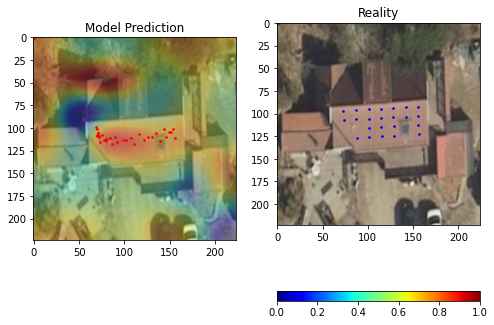

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="jet"), location = "bottom")
ax[0].imshow(image_plot)
ax[0].imshow(map[0][0].detach(), alpha=0.3, cmap ='jet')
ax[0].scatter(prediction[:, 1], prediction[:, 0], s=10, marker='.', c='r')
# ax[0].x_ticks()
ax[0].set_title("Model Prediction")

ax[1].imshow(image_plot)
ax[1].scatter(centroid[:, 1], centroid[:, 0], s=10, marker='.', c='b')
ax[1].set_title("Reality")
plt.show()